# TinyMS LeNet5 Tutorial

In this tutorial, constructing a LeNet5 model, downloading dataset, training, starting the server and making predictions of the model using TinyMS API will be demonstrated. 

## Prerequisite
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - opencv-python: `4.5.1.48`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## Introduction

TinyMS is a high-level API which is designed for amateur of deep learning. It minimizes the number of actions of users required to construct, train, evaluate and serve a model. TinyMS also provides tutorials and documentations for developers. 

This tutorial consists of six parts, `constructing the model`, `downloading dataset`, `training`, `define servable json`, `starting server` and `making predictions` in which the server will be run in a sub process.

In [1]:
import os
import json
import tinyms as ts
import tinyms.optimizers as opt

from PIL import Image
from tinyms import context
from tinyms.data import MnistDataset, download_dataset
from tinyms.vision import mnist_transform
from tinyms.model import Model, lenet5
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.metrics import Accuracy
from tinyms.losses import SoftmaxCrossEntropyWithLogits
from tinyms.callbacks import ModelCheckpoint, CheckpointConfig, LossMonitor

[WARNING] ME(11711:140661951510336,MainProcess):2021-03-17-11:47:37.600.288 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. Construct the model

TinyMS encapsulates init and construct of the LeNet5 model, the line of the code is reduced to construct the LeNet5 model:

In [2]:
# build the network
net = lenet5(class_num=10)
model = Model(net)

### 2. Download dataset

The MNIST dataset will be downloaded if `mnist` folder didn't exist at the root. If `mnist` folder already exists, this step will not be performed.

In [3]:
# download the dataset
mnist_path = '/root/mnist'
if not os.path.exists(mnist_path):
    ts.data.download_dataset('mnist', '/root')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************** Downloading the MNIST dataset **************
[████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%
============== /root/mnist/train/train-images-idx3-ubyte.gz is already ==============
[████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%
============== /root/mnist/train/train-labels-idx1-ubyte.gz is already ==============
[████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%
============== /root/mnist/test/t10k-images-idx3-ubyte.gz is already ==============
[████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%
============== /root/mnist/test/t10k-labels-idx1-ubyte.gz is already ==============
************Download complete*************


### 3. Train the model & evaluation

The dataset for both training and evaluation will be defined here, and the parameters for training also set in this block. A trained ckpt file will be saved to `/etc/tinyms/serving/lenet5` folder for later use, meanwhile the evaluation will be performed and the `Accuracy` can be checked

In [4]:
# check lenet folder exists or not
ckpt_folder = '/etc/tinyms/serving/lenet5'
ckpt_path = '/etc/tinyms/serving/lenet5/lenet5.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/lenet5
else:
    print('lenet5 ckpt folder already exists')

# set environment parameters
device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)  
dataset_sink_mode = False

# define the training and evaluation dataset
train_dataset = MnistDataset(os.path.join(mnist_path, "train"), shuffle=True)
train_dataset = mnist_transform.apply_ds(train_dataset)
eval_dataset = MnistDataset(os.path.join(mnist_path, "test"), shuffle=True)
eval_dataset = mnist_transform.apply_ds(eval_dataset)

# parameters for training
lr = 0.01
momentum = 0.9
epoch_size = 1
batch_size = 32

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# define the optimizer
net_opt = opt.Momentum(net.trainable_params(), lr, momentum)
net_metrics={"Accuracy": Accuracy()}
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics=net_metrics)

print('************************Start training*************************')
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10))
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, LossMonitor()],dataset_sink_mode=dataset_sink_mode)
print('************************Finished training*************************')
model.save_checkpoint(ckpt_path)


model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

lenet5 ckpt folder already exists
************************Start training*************************
epoch: 1 step: 1, loss is 2.3025925
epoch: 1 step: 2, loss is 2.302628
epoch: 1 step: 3, loss is 2.302569
epoch: 1 step: 4, loss is 2.3028355
epoch: 1 step: 5, loss is 2.3022976
epoch: 1 step: 6, loss is 2.3023846
epoch: 1 step: 7, loss is 2.30307
epoch: 1 step: 8, loss is 2.3017108
epoch: 1 step: 9, loss is 2.3026295
epoch: 1 step: 10, loss is 2.3037372
epoch: 1 step: 11, loss is 2.3028166
epoch: 1 step: 12, loss is 2.3027778
epoch: 1 step: 13, loss is 2.3010583
epoch: 1 step: 14, loss is 2.303954
epoch: 1 step: 15, loss is 2.3019102
epoch: 1 step: 16, loss is 2.301164
epoch: 1 step: 17, loss is 2.3062768
epoch: 1 step: 18, loss is 2.301557
epoch: 1 step: 19, loss is 2.3004386
epoch: 1 step: 20, loss is 2.300065
epoch: 1 step: 21, loss is 2.301045
epoch: 1 step: 22, loss is 2.3027081
epoch: 1 step: 23, loss is 2.3062322
epoch: 1 step: 24, loss is 2.3001027
epoch: 1 step: 25, loss is 2.301

epoch: 1 step: 219, loss is 2.28851
epoch: 1 step: 220, loss is 2.3005345
epoch: 1 step: 221, loss is 2.2895362
epoch: 1 step: 222, loss is 2.304596
epoch: 1 step: 223, loss is 2.3010707
epoch: 1 step: 224, loss is 2.313743
epoch: 1 step: 225, loss is 2.2963011
epoch: 1 step: 226, loss is 2.3023293
epoch: 1 step: 227, loss is 2.3180149
epoch: 1 step: 228, loss is 2.291154
epoch: 1 step: 229, loss is 2.299264
epoch: 1 step: 230, loss is 2.2969563
epoch: 1 step: 231, loss is 2.3065684
epoch: 1 step: 232, loss is 2.2866714
epoch: 1 step: 233, loss is 2.301034
epoch: 1 step: 234, loss is 2.2969818
epoch: 1 step: 235, loss is 2.3231783
epoch: 1 step: 236, loss is 2.2968955
epoch: 1 step: 237, loss is 2.3250144
epoch: 1 step: 238, loss is 2.2995288
epoch: 1 step: 239, loss is 2.2931275
epoch: 1 step: 240, loss is 2.2980835
epoch: 1 step: 241, loss is 2.3036187
epoch: 1 step: 242, loss is 2.312397
epoch: 1 step: 243, loss is 2.2856166
epoch: 1 step: 244, loss is 2.2674377
epoch: 1 step: 245, 

epoch: 1 step: 437, loss is 2.3145993
epoch: 1 step: 438, loss is 2.2950926
epoch: 1 step: 439, loss is 2.308606
epoch: 1 step: 440, loss is 2.3115516
epoch: 1 step: 441, loss is 2.3252168
epoch: 1 step: 442, loss is 2.2952497
epoch: 1 step: 443, loss is 2.2942939
epoch: 1 step: 444, loss is 2.296428
epoch: 1 step: 445, loss is 2.301
epoch: 1 step: 446, loss is 2.2752087
epoch: 1 step: 447, loss is 2.2788482
epoch: 1 step: 448, loss is 2.3031545
epoch: 1 step: 449, loss is 2.306693
epoch: 1 step: 450, loss is 2.2956605
epoch: 1 step: 451, loss is 2.3294692
epoch: 1 step: 452, loss is 2.3027165
epoch: 1 step: 453, loss is 2.3114824
epoch: 1 step: 454, loss is 2.2863753
epoch: 1 step: 455, loss is 2.2939892
epoch: 1 step: 456, loss is 2.3136656
epoch: 1 step: 457, loss is 2.332915
epoch: 1 step: 458, loss is 2.2972908
epoch: 1 step: 459, loss is 2.3041227
epoch: 1 step: 460, loss is 2.3156846
epoch: 1 step: 461, loss is 2.3226008
epoch: 1 step: 462, loss is 2.2813306
epoch: 1 step: 463, 

epoch: 1 step: 655, loss is 2.3102322
epoch: 1 step: 656, loss is 2.2913764
epoch: 1 step: 657, loss is 2.295873
epoch: 1 step: 658, loss is 2.307621
epoch: 1 step: 659, loss is 2.2850494
epoch: 1 step: 660, loss is 2.297321
epoch: 1 step: 661, loss is 2.28621
epoch: 1 step: 662, loss is 2.313583
epoch: 1 step: 663, loss is 2.2948415
epoch: 1 step: 664, loss is 2.293938
epoch: 1 step: 665, loss is 2.315714
epoch: 1 step: 666, loss is 2.3073995
epoch: 1 step: 667, loss is 2.332832
epoch: 1 step: 668, loss is 2.2968216
epoch: 1 step: 669, loss is 2.2948122
epoch: 1 step: 670, loss is 2.3037162
epoch: 1 step: 671, loss is 2.3017802
epoch: 1 step: 672, loss is 2.2979
epoch: 1 step: 673, loss is 2.3237748
epoch: 1 step: 674, loss is 2.315301
epoch: 1 step: 675, loss is 2.29055
epoch: 1 step: 676, loss is 2.3049011
epoch: 1 step: 677, loss is 2.3190386
epoch: 1 step: 678, loss is 2.3030374
epoch: 1 step: 679, loss is 2.3275535
epoch: 1 step: 680, loss is 2.2975557
epoch: 1 step: 681, loss is

epoch: 1 step: 873, loss is 2.3031623
epoch: 1 step: 874, loss is 2.2871537
epoch: 1 step: 875, loss is 2.3017702
epoch: 1 step: 876, loss is 2.3099978
epoch: 1 step: 877, loss is 2.313296
epoch: 1 step: 878, loss is 2.3091583
epoch: 1 step: 879, loss is 2.3114018
epoch: 1 step: 880, loss is 2.2971528
epoch: 1 step: 881, loss is 2.3112898
epoch: 1 step: 882, loss is 2.29563
epoch: 1 step: 883, loss is 2.2977839
epoch: 1 step: 884, loss is 2.2919216
epoch: 1 step: 885, loss is 2.2891948
epoch: 1 step: 886, loss is 2.309874
epoch: 1 step: 887, loss is 2.3052676
epoch: 1 step: 888, loss is 2.3004248
epoch: 1 step: 889, loss is 2.2973936
epoch: 1 step: 890, loss is 2.2825267
epoch: 1 step: 891, loss is 2.299543
epoch: 1 step: 892, loss is 2.295973
epoch: 1 step: 893, loss is 2.2887182
epoch: 1 step: 894, loss is 2.3178341
epoch: 1 step: 895, loss is 2.290558
epoch: 1 step: 896, loss is 2.2920232
epoch: 1 step: 897, loss is 2.3054895
epoch: 1 step: 898, loss is 2.2950099
epoch: 1 step: 899,

epoch: 1 step: 1088, loss is 2.2675424
epoch: 1 step: 1089, loss is 2.2616596
epoch: 1 step: 1090, loss is 2.249545
epoch: 1 step: 1091, loss is 2.252111
epoch: 1 step: 1092, loss is 2.264727
epoch: 1 step: 1093, loss is 2.248279
epoch: 1 step: 1094, loss is 2.2439728
epoch: 1 step: 1095, loss is 2.2381198
epoch: 1 step: 1096, loss is 2.2190907
epoch: 1 step: 1097, loss is 2.2336812
epoch: 1 step: 1098, loss is 2.2016509
epoch: 1 step: 1099, loss is 2.2105992
epoch: 1 step: 1100, loss is 2.2064588
epoch: 1 step: 1101, loss is 2.1868873
epoch: 1 step: 1102, loss is 2.1646192
epoch: 1 step: 1103, loss is 2.1826506
epoch: 1 step: 1104, loss is 2.1500094
epoch: 1 step: 1105, loss is 2.1318865
epoch: 1 step: 1106, loss is 2.165578
epoch: 1 step: 1107, loss is 2.1332889
epoch: 1 step: 1108, loss is 2.0587566
epoch: 1 step: 1109, loss is 2.0721748
epoch: 1 step: 1110, loss is 2.1108203
epoch: 1 step: 1111, loss is 1.9950761
epoch: 1 step: 1112, loss is 1.9934865
epoch: 1 step: 1113, loss is 1

epoch: 1 step: 1297, loss is 0.3854781
epoch: 1 step: 1298, loss is 0.32408315
epoch: 1 step: 1299, loss is 0.45080662
epoch: 1 step: 1300, loss is 0.34287444
epoch: 1 step: 1301, loss is 0.1597861
epoch: 1 step: 1302, loss is 0.3018836
epoch: 1 step: 1303, loss is 0.08226354
epoch: 1 step: 1304, loss is 0.21084036
epoch: 1 step: 1305, loss is 0.24858579
epoch: 1 step: 1306, loss is 0.19615841
epoch: 1 step: 1307, loss is 0.11026871
epoch: 1 step: 1308, loss is 0.26140866
epoch: 1 step: 1309, loss is 0.18871139
epoch: 1 step: 1310, loss is 0.55763274
epoch: 1 step: 1311, loss is 0.5341658
epoch: 1 step: 1312, loss is 0.16067365
epoch: 1 step: 1313, loss is 0.38775754
epoch: 1 step: 1314, loss is 0.34632853
epoch: 1 step: 1315, loss is 0.4954602
epoch: 1 step: 1316, loss is 0.5197998
epoch: 1 step: 1317, loss is 0.2841068
epoch: 1 step: 1318, loss is 0.22425379
epoch: 1 step: 1319, loss is 0.26798826
epoch: 1 step: 1320, loss is 0.74513364
epoch: 1 step: 1321, loss is 0.2402286
epoch: 1

epoch: 1 step: 1503, loss is 0.04577511
epoch: 1 step: 1504, loss is 0.4675565
epoch: 1 step: 1505, loss is 0.24827078
epoch: 1 step: 1506, loss is 0.08002991
epoch: 1 step: 1507, loss is 0.13118
epoch: 1 step: 1508, loss is 0.18158872
epoch: 1 step: 1509, loss is 0.26966745
epoch: 1 step: 1510, loss is 0.038586423
epoch: 1 step: 1511, loss is 0.10896028
epoch: 1 step: 1512, loss is 0.3801732
epoch: 1 step: 1513, loss is 0.20102066
epoch: 1 step: 1514, loss is 0.16724867
epoch: 1 step: 1515, loss is 0.36633563
epoch: 1 step: 1516, loss is 0.51239884
epoch: 1 step: 1517, loss is 0.18913437
epoch: 1 step: 1518, loss is 0.26655206
epoch: 1 step: 1519, loss is 0.17314501
epoch: 1 step: 1520, loss is 0.33429506
epoch: 1 step: 1521, loss is 0.14127572
epoch: 1 step: 1522, loss is 0.36285126
epoch: 1 step: 1523, loss is 0.22072968
epoch: 1 step: 1524, loss is 0.25411192
epoch: 1 step: 1525, loss is 0.48943597
epoch: 1 step: 1526, loss is 0.20597874
epoch: 1 step: 1527, loss is 0.3810883
epoch

epoch: 1 step: 1709, loss is 0.18996589
epoch: 1 step: 1710, loss is 0.09848397
epoch: 1 step: 1711, loss is 0.2514619
epoch: 1 step: 1712, loss is 0.11584256
epoch: 1 step: 1713, loss is 0.4023314
epoch: 1 step: 1714, loss is 0.03728634
epoch: 1 step: 1715, loss is 0.03335476
epoch: 1 step: 1716, loss is 0.18455644
epoch: 1 step: 1717, loss is 0.18693241
epoch: 1 step: 1718, loss is 0.31938165
epoch: 1 step: 1719, loss is 0.06800351
epoch: 1 step: 1720, loss is 0.1716736
epoch: 1 step: 1721, loss is 0.0856242
epoch: 1 step: 1722, loss is 0.10138575
epoch: 1 step: 1723, loss is 0.17525963
epoch: 1 step: 1724, loss is 0.37821215
epoch: 1 step: 1725, loss is 0.44712958
epoch: 1 step: 1726, loss is 0.1273179
epoch: 1 step: 1727, loss is 0.4621757
epoch: 1 step: 1728, loss is 0.31960788
epoch: 1 step: 1729, loss is 0.059619106
epoch: 1 step: 1730, loss is 0.13064215
epoch: 1 step: 1731, loss is 0.1883901
epoch: 1 step: 1732, loss is 0.52841705
epoch: 1 step: 1733, loss is 0.10057476
epoch:

### 4. Define servable.json

Define the lenet5 servable json file for model name, format and number of classes for serving. 

In [5]:
servable_json = [{'name': 'lenet5', 
                  'description': 'This servable hosts a lenet5 model predicting numbers', 
                  'model': {
                      "name": "lenet5", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. Start server

#### 5.1 Introduction
TinyMS Serving is a C/S(client/server) structure. TinyMS using [Flask](https://flask.palletsprojects.com/en/1.1.x/) which is a micro web framework written in python as the C/S communication tool. In order to serve a model, user must start server first. If successfully started, the server will be run in a subprocess and listening to POST requests from 127.0.0.1 port 5000 sent by client and handle the requests using MindSpore backend which constructs the model, run the prediction and send the result back to the client.

#### 5.2 Start server

Run the following code block to start the server:

In [6]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 6. Make predictions

#### 6.1 Upload the pic

A picture of a single digit number is required to be the input. The picture we use in this tutorial can be found [HERE](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png), then save the picture to the root folder, and rename it to `7.png` (or any other name you like).

Or run the following code to download the pic for this tutorial:

In [7]:
if not os.path.exists('/root/7.png'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
else:
    print('7.png already exists')

--2021-03-17 11:54:41--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 121.36.121.44, 49.4.112.90, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|121.36.121.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34970 (34K) [image/png]
Saving to: ‘/root/7.png’

7.png               100%[===================>]  34.15K  --.-KB/s    in 0.06s   

2021-03-17 11:54:43 (581 KB/s) - ‘/root/7.png’ saved [34970/34970]



#### 6.2 List servables

Use `list_servables` function to check what model is being served right now.

In [8]:
list_servables()

[{'description': 'This servable hosts a lenet5 model predicting numbers',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'lenet5'},
  'name': 'lenet5'}]

If the output `description` shows it is a `lenet5` model, then we can continue to next step to send our request.

#### 6.3 Sending request and get the result

Run `predict` function to send the request, select between `TOP1_CLASS` and `TOP5_CLASS`:

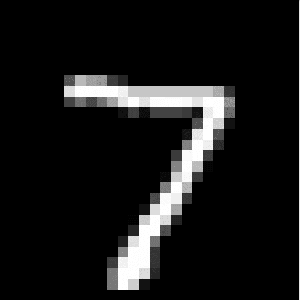

TOP1: 7, score: 0.99962902069091796875


In [9]:
image_path = "/root/7.png"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset='mnist', strategy='TOP1_CLASS')
if server_started() is True:
    display(Image.open(image_path).resize((300, 300), Image.ANTIALIAS))
    print(predict(image_path, 'lenet5', 'mnist', strategy))
else:
    print("Server not started")

If user can see the output similar to this:  
```
TOP1: 7, score: 0.99934917688369750977
```
that means the prediction is successfully performed

## Shutdown server

In [10]:
shutdown()

'Server shutting down...'